### Imports

In [1]:
# Libraries
import os
from importlib import reload
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

# Scripts
from helpers import data, runners, utils

In [2]:
!pip show tensorflow # Should be v2.10

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [3]:
!pip show keras # Should be v2.10

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [4]:
reload(runners)
reload(data)
reload(utils)

<module 'helpers.utils' from 'c:\\Users\\sonar\\Desktop\\thesis-ml\\ml\\main\\helpers\\utils.py'>

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

### Load data

In [6]:
N_FOLDS = 10
DATA_BATCH_SIZE = 32
GPU_BATCH_SIZE = 16
EPOCHS = 10


In [7]:
fold_dfs = data.get_fold_dfs(
    fold_definition_csv="../data/DATASET_CSVS/deepship_5k_seg_3s.csv",
    new_path_to_root="../data/deepship_baseline_mat",
    ext="mat", 
    n_folds=N_FOLDS,
    unix=False
)

In [8]:
train_df, test_df = data.generate_kth_fold(fold_dfs, test_idx=0, val_idx=None)

print(train_df.shape)
print(test_df.shape)

del fold_dfs

(48968, 5)
(4534, 5)


In [9]:
train_gen = data.DeepShipGenerator(
    train_df,
    ext="mat",
    mat_var_name="Pexp",
    batch_size=DATA_BATCH_SIZE,
    shuffle=True,
    X_only=True
)

test_gen = data.DeepShipGenerator(
    test_df,
    ext="mat",
    mat_var_name="Pexp",
    batch_size=DATA_BATCH_SIZE,
    shuffle=False,
    X_only=True
)

### Initialise model

In [10]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000, 
    decay_rate=0.9 
)

In [11]:
from models.denoising import irfan_2020
reload(irfan_2020)

irfan = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))

irfan.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr]
)

irfan.summary()

Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3

### Train model

In [ ]:
# 10 folds, 2 epochs ~ 13min
# 10 folds, 10 epochs ~ 60 min

history = irfan.fit(
    train_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/10
1530/1530 - 362s - loss: 0.0948 - psnr: 15.3671 - 362s/epoch - 237ms/step
Epoch 2/10
1530/1530 - 340s - loss: 0.0125 - psnr: 19.1746 - 340s/epoch - 222ms/step
Epoch 3/10
1530/1530 - 331s - loss: 0.0117 - psnr: 19.4494 - 331s/epoch - 216ms/step
Epoch 4/10
1530/1530 - 352s - loss: 0.0112 - psnr: 19.6292 - 352s/epoch - 230ms/step
Epoch 5/10
1530/1530 - 352s - loss: 0.0107 - psnr: 19.8554 - 352s/epoch - 230ms/step
Epoch 6/10
1530/1530 - 348s - loss: 0.0102 - psnr: 20.0572 - 348s/epoch - 227ms/step
Epoch 7/10
1530/1530 - 345s - loss: 0.0098 - psnr: 20.2382 - 345s/epoch - 226ms/step
Epoch 8/10
1530/1530 - 386s - loss: 0.0094 - psnr: 20.4108 - 386s/epoch - 252ms/step
Epoch 9/10
1530/1530 - 401s - loss: 0.0091 - psnr: 20.5308 - 401s/epoch - 262ms/step
Epoch 10/10
1530/1530 - 370s - loss: 0.0100 - psnr: 20.1733 - 370s/epoch - 242ms/step


In [13]:
evals = irfan.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

141/141 - 11s - loss: 0.0107 - psnr: 19.8484 - 11s/epoch - 75ms/step


In [ ]:
irfan.save("models/saved/irfan_denoising_11112024/irfan_denoiser.keras")

### Evaluation, metrics, and visualising denoised output

In [15]:
# Get a few samples from the test generator for visualisation and metrics calculation
num_samples = 5 

sample_batch = next(iter(test_gen))[0]
sample_inputs = sample_batch[:num_samples]  # Extract the first `num_samples` examples from the batch

# Predict the denoised outputs
denoised_outputs = irfan.predict(sample_inputs)

1/1 [==============================] - 1s 750ms/step


In [16]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE on sample batch: {mse_score}")
print(f"PSNR on sample batch: {psnr_score}")

MSE on sample batch: 0.011011432856321335
PSNR on sample batch: [18.260252 21.474394 19.519913 18.902798 20.474152]


In [17]:
# Check if all outputs are normalised
for i, output in enumerate(denoised_outputs):
    print(f"Sample {i+1} - Min: {np.min(output)}; Max: {np.max(output)}")

Sample 1 - Min: 0.2608981728553772; Max: 0.8291928768157959
Sample 2 - Min: 0.20905424654483795; Max: 0.8194042444229126
Sample 3 - Min: 0.17707356810569763; Max: 0.784909188747406
Sample 4 - Min: 0.130833700299263; Max: 0.828173816204071
Sample 5 - Min: 0.14799851179122925; Max: 0.8042110800743103


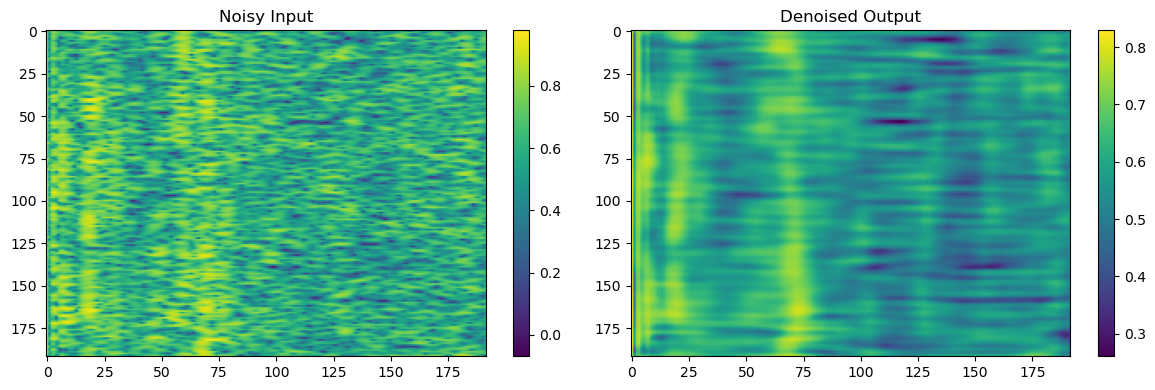

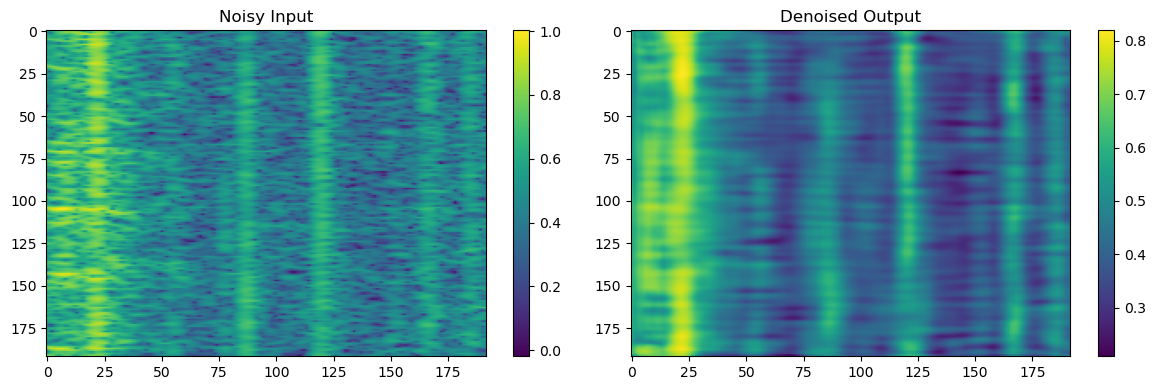

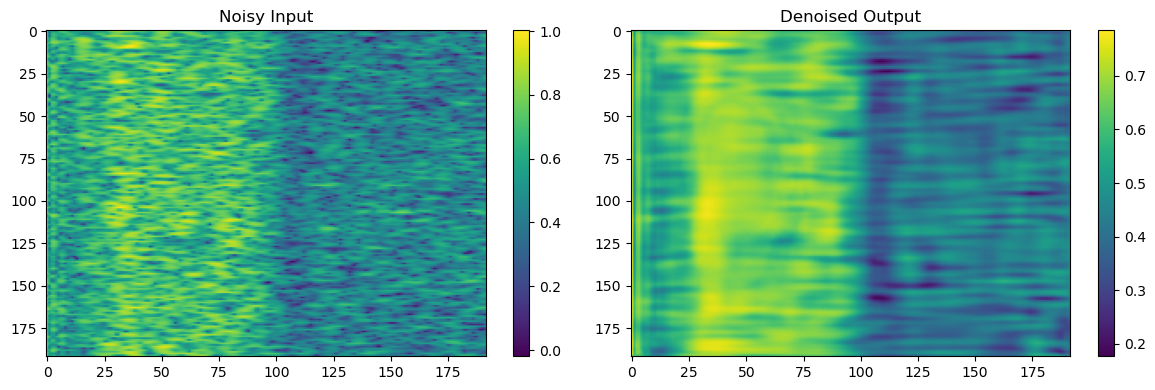

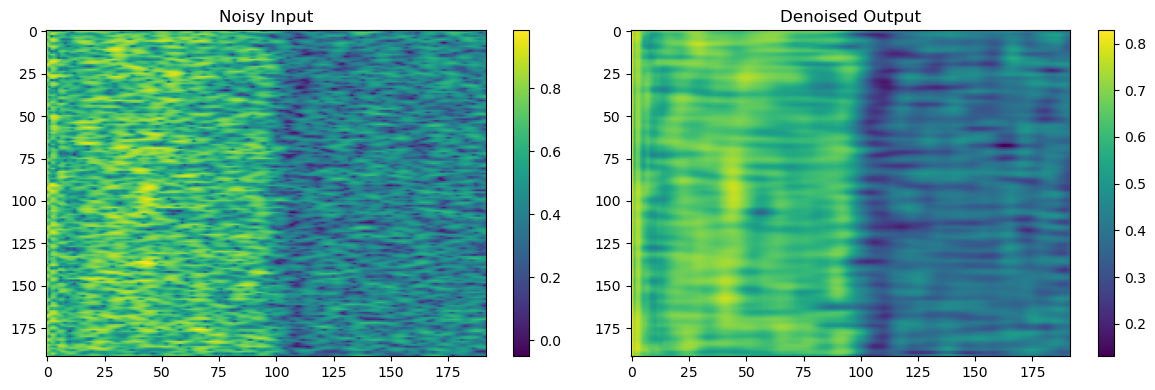

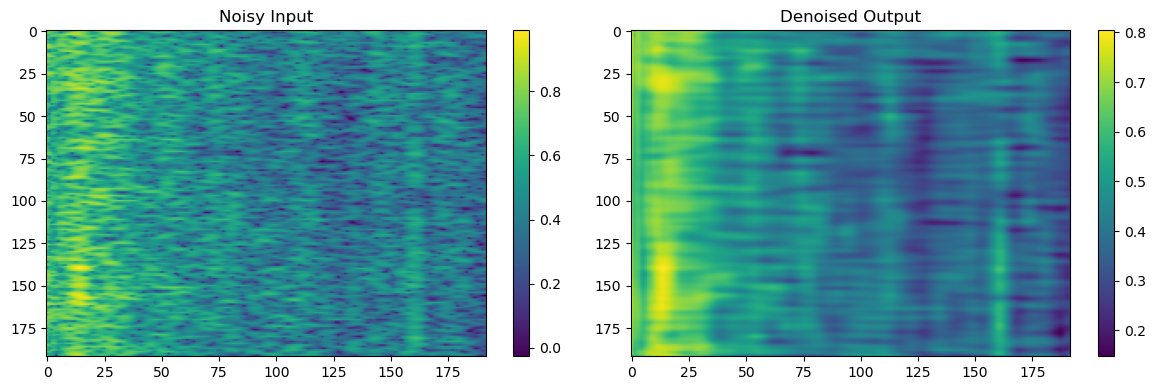

In [18]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    fig = plt.figure(figsize=(12, 4))
    
    # Noisy Input
    plt.subplot(1, 2, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input")
    plt.colorbar()

    # Denoised Output
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # fig.savefig(f"models/img/irfan_denoise/ex{i + 1}.png")